In [1]:
"""
# Hot Strip Rolling Dataset Analysis & Baseline Machine Learning
This notebook:
1. Loads and explores the dataset.
2. Performs quick exploratory data analysis (EDA).
3. Runs baseline ML regressors (Linear, Random Forest, Gradient Boosting, KNN, SVM, MLP)
   on each numeric target column.
4. Reports R², RMSE, and MAE for each target/model pair.
5. Saves all results into `initial_ml_results.csv`.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR                      
from sklearn.neural_network import MLPRegressor 

SEED = 42
np.random.seed(SEED)


In [2]:
# Load dataset
CSV_PATH = Path("hot_strip_rolling_data (1).csv")  # adjust if needed
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at: {CSV_PATH.resolve()}")

df = pd.read_csv(CSV_PATH)

print(f"Rows: {df.shape[0]}  Columns: {df.shape[1]}")
display(df.head(10))


Rows: 1000  Columns: 14


,entry_temperature,exit_temperature,rolling_speed,strip_thickness,material_grade,deformation_resistance,friction_coefficient,roll_diameter,reduction_ratio,strain_rate,lubrication_type,material_grade_encoded,lubrication_type_encoded,bending_force
0,1174.84,941.98,2.72,24.54,A36,154.86,0.245,653.22,0.36,0.58,oil,0,1,1222.80
1,1143.09,927.74,1.70,28.45,A36,108.36,0.215,640.43,0.30,0.80,oil,0,1,1089.33
2,1182.38,901.79,2.55,32.06,A36,161.06,0.230,668.79,0.36,0.74,water-based,0,2,1224.46
3,1226.15,880.59,1.83,22.06,AISI 304,139.04,0.106,647.60,0.40,0.66,dry,1,0,1101.68
4,1138.29,920.95,3.92,28.71,SS400,188.47,0.224,656.15,0.33,0.92,oil,3,1,1205.19
5,1138.29,911.80,4.34,27.58,A36,134.51,0.202,601.30,0.41,0.87,water-based,0,2,1178.42
6,1228.96,926.86,1.72,22.16,SS400,116.22,0.209,706.65,0.46,0.80,dry,3,0,1272.58
7,1188.37,919.06,4.37,29.36,AISI 316,140.57,0.172,645.07,0.25,0.94,water-based,2,2,1142.74
8,1126.53,931.49,3.07,24.10,AISI 316,110.49,0.116,670.93,0.34,0.87,oil,2,1,1068.34
9,1177.13,883.94,2.40,27.32,A36,165.02,0.139,624.92,0.32,0.72,water-based,0,2,1184.21


In [6]:
# Summaries
display(df.describe().T)

# Show missing values
missing = df.isna().sum().sort_values(ascending=False)
display(missing.to_frame("Missing Count").head(20))

# Mean, median, and standard deviation of numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove encoded categorical columns if present
numeric_cols.remove('material_grade_encoded') if 'material_grade_encoded' in numeric_cols else None
numeric_cols.remove('lubrication_type_encoded') if 'lubrication_type_encoded' in numeric_cols else None

non_numeric_cols = [c for c in df.columns if c not in numeric_cols]

print("Numeric columns:", len(numeric_cols))
print("Non-numeric columns:", len(non_numeric_cols))

summary_stats = pd.DataFrame({
    "mean": df[numeric_cols].mean(),
    "median": df[numeric_cols].median(),
    "std": df[numeric_cols].std(),
})
display(summary_stats.round(3))

,count,mean,std,min,25%,50%,75%,max
entry_temperature,1000.0,1150.966520,48.960869,987.94,1117.6200,1151.265,1182.3950,1342.64
exit_temperature,1000.0,902.125080,29.923743,811.79,881.8150,901.890,921.8675,995.79
rolling_speed,1000.0,2.990630,0.870698,1.50,2.2400,3.000,3.7425,4.50
strip_thickness,1000.0,27.272550,4.253369,20.00,23.5575,27.240,30.8400,34.99
deformation_resistance,1000.0,148.749650,19.856296,86.47,136.0325,149.450,162.6700,211.54
friction_coefficient,1000.0,0.198992,0.058109,0.10,0.1490,0.197,0.2510,0.30
roll_diameter,1000.0,648.881650,30.963022,563.01,627.1800,648.635,670.5050,742.95
reduction_ratio,1000.0,0.347400,0.083661,0.20,0.2800,0.350,0.4200,0.50
strain_rate,1000.0,0.802770,0.103627,0.42,0.7300,0.800,0.8700,1.14
material_grade_encoded,1000.0,1.465000,1.103627,0.00,0.7500,1.000,2.0000,3.00


,Missing Count
entry_temperature,0
exit_temperature,0
rolling_speed,0
strip_thickness,0
material_grade,0
deformation_resistance,0
friction_coefficient,0
roll_diameter,0
reduction_ratio,0
strain_rate,0


Numeric columns: 10
Non-numeric columns: 4


,mean,median,std
entry_temperature,1150.967,1151.265,48.961
exit_temperature,902.125,901.890,29.924
rolling_speed,2.991,3.000,0.871
strip_thickness,27.273,27.240,4.253
deformation_resistance,148.750,149.450,19.856
friction_coefficient,0.199,0.197,0.058
roll_diameter,648.882,648.635,30.963
reduction_ratio,0.347,0.350,0.084
strain_rate,0.803,0.800,0.104
bending_force,1133.280,1135.010,73.114


<Figure size 1600x1000 with 0 Axes>

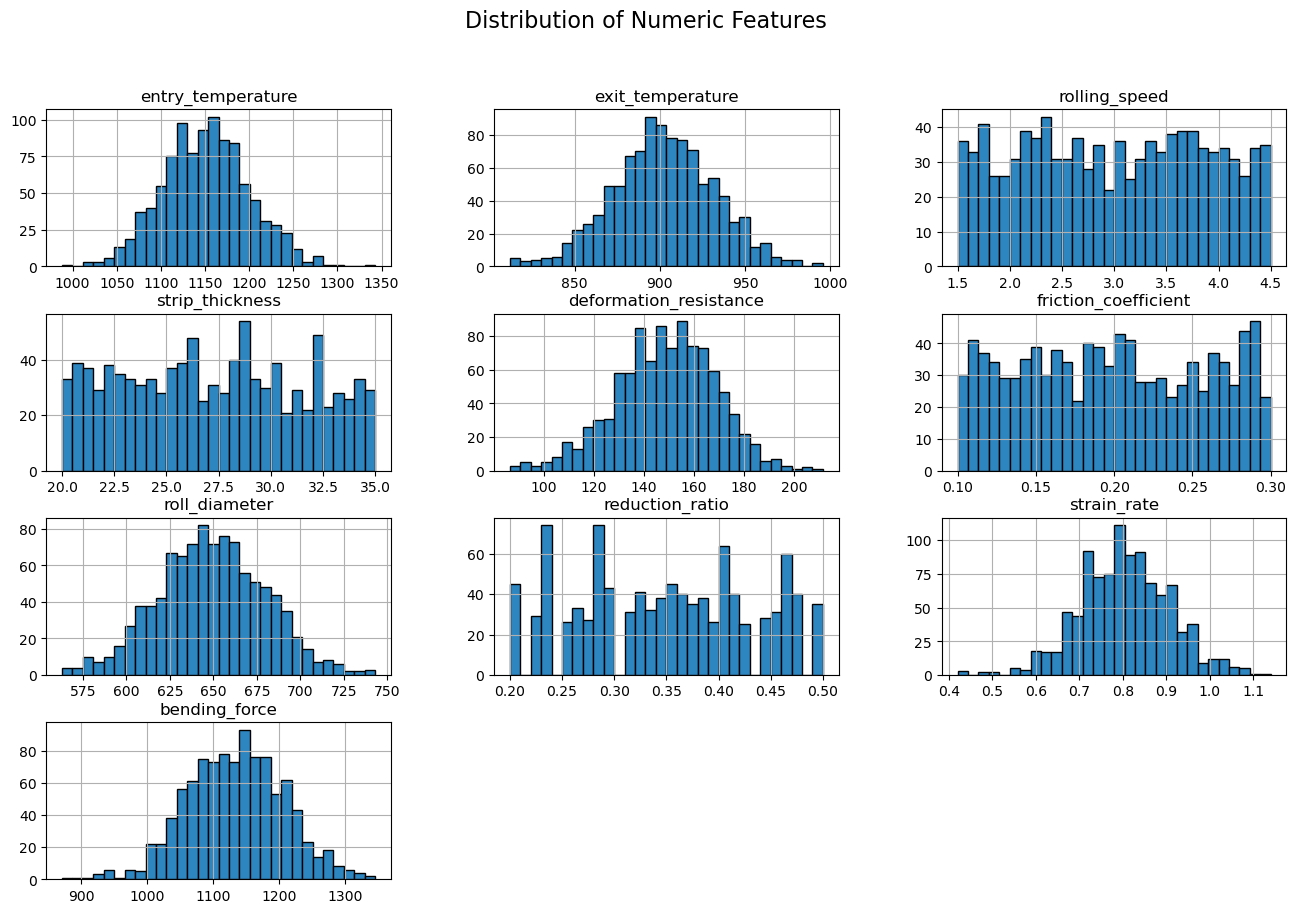

In [7]:
# Plot histograms of numeric features
plt.figure(figsize=(16, 10))
df[numeric_cols].hist(bins=30, figsize=(16, 10), color="#2E86C1", edgecolor="black")
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()


In [8]:
# Try to find a target column that represents "bending force"
target_col = df.columns[df.columns.str.contains("bending_force", case=False)]
if target_col is None:
    raise ValueError(
        "Could not auto-detect the bending force column. "
        "Please rename the target column to include both words 'bending' and 'force', "
        "or set target_col manually here."
    )

print("Selected target column for bending force:", target_col)


Selected target column for bending force: Index(['bending_force'], dtype='object')


In [9]:
# Features: all columns except the target
feature_cols_numeric = [c for c in numeric_cols if c != target_col]
feature_cols_categ = non_numeric_cols.copy()
used_feature_cols = feature_cols_numeric + feature_cols_categ

print(f"Using {len(used_feature_cols)} features "
      f"({len(feature_cols_numeric)} numeric, {len(feature_cols_categ)} categorical).")

X = df[used_feature_cols].copy()
y = df[target_col].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, feature_cols_numeric),
    ("cat", categorical_transformer, feature_cols_categ),
])

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=SEED),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel="rbf", C=1.0, gamma="scale"),
    "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), activation="relu",
                        solver="adam", random_state=SEED,
                        max_iter=500, early_stopping=True)
}



Using 13 features (9 numeric, 4 categorical).


In [10]:
rows = []
for model_name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("regressor", model),
    ])
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_valid)

        r2 = r2_score(y_valid, y_pred)
        rmse = mean_squared_error(y_valid, y_pred)
        mae = mean_absolute_error(y_valid, y_pred)

        rows.append({
            "target": target_col,
            "model": model_name,
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae,
            "n_train": len(X_train),
            "n_valid": len(X_valid),
            "features_used": len(used_feature_cols)
        })
    except Exception as e:
        rows.append({
            "target": target_col,
            "model": model_name,
            "R2": np.nan,
            "RMSE": np.nan,
            "MAE": np.nan,
            "n_train": len(X_train),
            "n_valid": len(X_valid),
            "features_used": len(used_feature_cols),
            "error": str(e)
        })

results_df = pd.DataFrame(rows).sort_values(by="R2", ascending=False).reset_index(drop=True)

print("=== Bending Force — Initial ML Results ===")
display(results_df)

results_df.to_csv("bending_force_initial_results.csv", index=False)
print("Saved to: bending_force_initial_results.csv")


C:\Users\magic\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\magic\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:

=== Bending Force — Initial ML Results ===


,target,model,R2,RMSE,MAE,n_train,n_valid,features_used
0,"Index(['bending_force'], dtype='object')",LinearRegression,0.538026,2564.485624,40.359322,800,200,13
1,"Index(['bending_force'], dtype='object')",GradientBoosting,0.525066,2636.430276,41.903041,800,200,13
2,"Index(['bending_force'], dtype='object')",RandomForest,0.511895,2709.542544,42.808165,800,200,13
3,"Index(['bending_force'], dtype='object')",MLP,0.471265,2935.088010,42.457803,800,200,13
4,"Index(['bending_force'], dtype='object')",KNN,0.279925,3997.245756,50.255160,800,200,13
5,"Index(['bending_force'], dtype='object')",SVR,0.173195,4589.719520,53.964641,800,200,13


Saved to: bending_force_initial_results.csv


Data Cleaning for `hot_strip_rolling_data (1).csv`

This section performs **dataset-specific data cleaning** to prepare it for ML model training.
The main cleaning steps are:

1. Remove duplicate rows.
2. Drop columns with more than 40% missing values.
3. Winsorize (clip) extreme outliers at the 1st and 99th percentiles.
4. Trim and lowercase text in categorical columns.
5. Exclude `material_grade_encode` and `lubrication_type_encode` when their corresponding categorical columns exist.
6. Save the cleaned dataset for comparison.


In [11]:


# Step 1: Remove duplicates
df_clean = df.drop_duplicates()

# Step 2: Drop columns with >40% missing values
missing_frac = df_clean.isna().mean()
drop_cols = missing_frac[missing_frac > 0.4].index.tolist()
if drop_cols:
    df_clean = df_clean.drop(columns=drop_cols)
print("Dropped columns (>40% missing):", drop_cols)

# Step 3: Winsorize numeric outliers
num_cols = df_clean.select_dtypes(include=[np.number]).columns
if len(num_cols) > 0:
    q_low = df_clean[num_cols].quantile(0.01)
    q_hi = df_clean[num_cols].quantile(0.99)
    df_clean[num_cols] = df_clean[num_cols].clip(lower=q_low, upper=q_hi, axis=1)

# Step 4: Clean categorical columns
obj_cols = df_clean.select_dtypes(include=['object']).columns
for c in obj_cols:
    df_clean[c] = df_clean[c].astype(str).str.strip().str.lower()

# Step 5: Exclude encoded numeric columns when categorical ones exist
excluded = []
if 'material_grade' in df_clean.columns and 'material_grade_encoded' in df_clean.columns:
    df_clean = df_clean.drop(columns=['material_grade_encoded'])
    excluded.append('material_grade_encoded')
if 'lubrication_type' in df_clean.columns and 'lubrication_type_encoded' in df_clean.columns:
    df_clean = df_clean.drop(columns=['lubrication_type_encoded'])
    excluded.append('lubrication_type_encoded')

# Save cleaned dataset
cleaned_file = "cleaned_dataset.csv"
df_clean.to_csv(cleaned_file, index=False)
print(df_clean.head())

print("Cleaned dataset saved as:", cleaned_file)
print("Final shape:", df_clean.shape)
print("Excluded encoded columns:", excluded)


Dropped columns (>40% missing): []
   entry_temperature  exit_temperature  rolling_speed  strip_thickness  \
0            1174.84            941.98           2.72            24.54   
1            1143.09            927.74           1.70            28.45   
2            1182.38            901.79           2.55            32.06   
3            1226.15            880.59           1.83            22.06   
4            1138.29            920.95           3.92            28.71   

  material_grade  deformation_resistance  friction_coefficient  roll_diameter  \
0            a36                  154.86                 0.245         653.22   
1            a36                  108.36                 0.215         640.43   
2            a36                  161.06                 0.230         668.79   
3       aisi 304                  139.04                 0.106         647.60   
4          ss400                  188.47                 0.224         656.15   

   reduction_ratio  strain_rate l

Compare ML Model Results Before vs After Cleaning

We now train several regression models using the **original dataset** and the **cleaned dataset**, 
then compare performance metrics such as R², RMSE, and MAE.


In [12]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Helper functions
def rmse_safe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def prep_features(df, target_col):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    non_numeric_cols = [c for c in df.columns if c not in numeric_cols]
    
    # Ensure encoded columns are excluded if categorical exist
    for pair in [('material_grade', 'material_grade_encode'),
                 ('lubrication_type', 'lubrication_type_encode')]:
        cat, enc = pair
        if cat in df.columns and enc in numeric_cols:
            numeric_cols.remove(enc)
            if cat not in non_numeric_cols:
                non_numeric_cols.append(cat)
    
    feature_cols_num = [c for c in numeric_cols if c != target_col]
    feature_cols_cat = non_numeric_cols.copy()
    
    X = df[feature_cols_num + feature_cols_cat]
    y = df[target_col]
    
    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    pre = ColumnTransformer([('num', num_pipe, feature_cols_num),
                             ('cat', cat_pipe, feature_cols_cat)])
    return X, y, pre

def run_models(df, target_col):
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
        "GradientBoosting": GradientBoostingRegressor(random_state=42),
        "KNN": KNeighborsRegressor(n_neighbors=5),
        "SVR": SVR(kernel='rbf', C=1.0, gamma='scale'),
        "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation='relu', solver='adam', max_iter=500, random_state=42, early_stopping=True)
    }
    
    X, y, pre = prep_features(df, 'bending_force')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rows = []
    for name, model in models.items():
        pipe = Pipeline([('prep', pre), ('model', model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        rows.append({
            "Model": name,
            "R2": r2_score(y_test, y_pred),
            "RMSE": rmse_safe(y_test, y_pred),
            "MAE": mean_absolute_error(y_test, y_pred)
        })
    return pd.DataFrame(rows).sort_values(by="R2", ascending=False)

# Load original and cleaned datasets
df_before = pd.read_csv(CSV_PATH)
df_after = pd.read_csv("cleaned_dataset.csv")

# Run models
results_before = run_models(df_before, 'bending_force')
results_after = run_models(df_after, 'bending_force')

# Combine for comparison
comparison = results_before.merge(results_after, on='Model', suffixes=('_Before', '_After'))
display(comparison)

# Save comparison
comparison.to_csv("model_comparison_before_after_cleaning.csv", index=False)
print("Saved model comparison to model_comparison_before_after_cleaning.csv")


C:\Users\magic\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,R2_Before,RMSE_Before,MAE_Before,R2_After,RMSE_After,MAE_After
0,LinearRegression,0.538026,50.640751,40.359322,0.544885,49.561592,39.824112
1,GradientBoosting,0.520171,51.610106,41.790705,0.528365,50.453079,41.163087
2,RandomForest,0.515064,51.884025,42.686562,0.510991,51.373941,42.503895
3,KNN,0.273612,63.500291,51.537170,0.319846,60.588235,48.318083
4,MLP,0.268984,63.702266,49.473887,0.389415,57.406048,45.246219
5,SVR,0.172168,67.789534,54.022160,0.193967,65.957009,52.969435


Saved model comparison to model_comparison_before_after_cleaning.csv


Visualization of R² Improvement After Cleaning


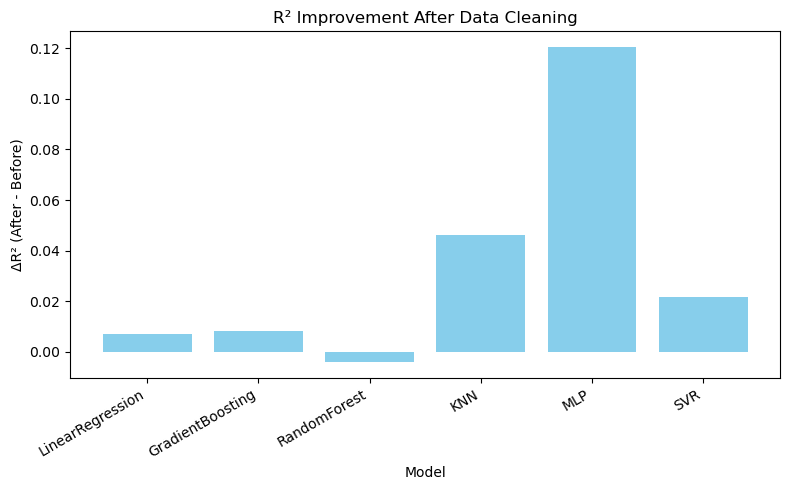

In [13]:

import matplotlib.pyplot as plt

# Plot R² improvement
comparison["R2_Improvement"] = comparison["R2_After"] - comparison["R2_Before"]
plt.figure(figsize=(8,5))
plt.bar(comparison["Model"], comparison["R2_Improvement"], color='skyblue')
plt.title("R² Improvement After Data Cleaning")
plt.xlabel("Model")
plt.ylabel("ΔR² (After - Before)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


## Hyperparameter Tuning on Cleaned Data, Model Comparison, and Saving Tuned Pipelines

This section:
- Loads `cleaned_dataset.csv` produced earlier,
- Recomputes **untuned baselines** on the cleaned data for a fair comparison,
- Performs **sequential** `GridSearchCV (cv=5)` for RF, GB, KNN, SVR, and MLP,
- **Saves the fitted best pipelines** (preprocessing + model) with `joblib.dump(...)`,
- Outputs a comparison table (untuned vs tuned) and saves results to CSV.


In [14]:
import pandas as pd, numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import joblib

SEED = 42
rng = np.random.RandomState(SEED)

cleaned_path = Path("cleaned_dataset.csv")
if not cleaned_path.exists():
    raise FileNotFoundError("cleaned_dataset.csv not found. Please run the cleaning section earlier to generate it.")

df = pd.read_csv(cleaned_path)
assert 'bending_force' in df.columns, "Expected 'bending_force' in the cleaned dataset."

def prep_features(df, target_col='bending_force'):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    # Exclude encoded versions if categorical exists
    if 'material_grade' in df.columns and 'material_grade_encode' in num_cols:
        num_cols.remove('material_grade_encode')
        if 'material_grade' not in cat_cols:
            cat_cols.append('material_grade')
    if 'lubrication_type' in df.columns and 'lubrication_type_encode' in num_cols:
        num_cols.remove('lubrication_type_encode')
        if 'lubrication_type' not in cat_cols:
            cat_cols.append('lubrication_type')
    # Guard for *_encoded spellings if present
    for col in ['material_grade_encoded','lubrication_type_encoded']:
        if col in num_cols:
            num_cols.remove(col)
            if col not in cat_cols:
                cat_cols.append(col)

    X = df[[c for c in num_cols if c != target_col] + cat_cols].copy()
    y = df[target_col].copy()

    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("onehot", OneHotEncoder(handle_unknown="ignore"))])
    pre = ColumnTransformer([("num", num_pipe, [c for c in num_cols if c != target_col]),
                             ("cat", cat_pipe, cat_cols)])
    return X, y, pre

X, y, pre = prep_features(df, target_col='bending_force')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

def rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# Untuned baselines on cleaned data
untuned = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=SEED),
    "GradientBoosting": GradientBoostingRegressor(random_state=SEED),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel="rbf", C=1.0, gamma="scale", epsilon=0.1),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                        solver="adam", random_state=SEED, max_iter=500, early_stopping=True)
}

rows = []
baseline_pipes = {}
for name, model in untuned.items():
    pipe = Pipeline([("pre", pre), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rows.append({"Model": name,
                 "R2_Untuned": r2_score(y_test, y_pred),
                 "RMSE_Untuned": rmse(y_test, y_pred),
                 "MAE_Untuned": mean_absolute_error(y_test, y_pred)})
    baseline_pipes[name] = pipe

baseline_df = pd.DataFrame(rows).sort_values("R2_Untuned", ascending=False)
baseline_df


C:\Users\magic\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,R2_Untuned,RMSE_Untuned,MAE_Untuned
0,LinearRegression,0.544885,49.561592,39.824112
2,GradientBoosting,0.528365,50.453079,41.163087
1,RandomForest,0.510991,51.373941,42.503895
5,MLP,0.389415,57.406048,45.246219
3,KNN,0.319846,60.588235,48.318083
4,SVR,0.193967,65.957009,52.969435


In [19]:
# Grids sized for ~1k rows; sequential (n_jobs=None)
grids = {
    "RandomForest": {
        "model__n_estimators":     [1100, 1200, 1300],
        "model__max_features":     ["sqrt", 0.7, 0.8],
        "model__max_depth":        [None, 5, 10],
        "model__min_samples_split":[2, 4, 6],
        "model__min_samples_leaf": [2, 4, 6]
    },
    "GradientBoosting": {
        "model__n_estimators":    [1100, 1200, 1300],
        "model__learning_rate":   [0.02, 0.03, 0.04],
        "model__max_depth":       [1, 2, 3],
        "model__subsample":       [0.7, 0.75, 0.8],
        "model__min_samples_leaf":[15, 20, 25],
        "model__loss":            ["squared_error", "huber"]
    },
    "KNN": {
        "model__n_neighbors": [10, 11, 12, 13, 14, 15, 16],
        "model__weights": ["uniform", "distance"],
        "model__p": [2, 3]
    },
    "SVR": {
        "model__kernel": ["rbf"],
        "model__C": [750, 800, 850],
        "model__gamma": [0.002, 0.0025],
        "model__epsilon": [0.35, 0.4, 0.5],
    },
    "MLP": {
        "model__hidden_layer_sizes": [(32,), (64,), (64,32), (128,), (128,64)],
        "model__activation": ["relu", "tanh"],
        "model__alpha": [0.002, 0.003, 0.005, 0.01],
        "model__learning_rate_init": [0.0015, 0.002, 0.003],
        "model__max_iter": [900],
        "model__early_stopping": [True]
    }
}


In [23]:
# tune the models on the defined grids
from sklearn.model_selection import GridSearchCV
import os

tuned_records = []
best_pipes = {}

def tune(name, base_model, grid):
    pipe = Pipeline([("pre", pre), ("model", base_model)])
    gs = GridSearchCV(pipe, grid, scoring="r2", cv=5, n_jobs=12, refit=True, verbose=0)  # change n_jobs as needed, set to None if not sure what to use
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    tuned_records.append({
        "Model": name,
        "R2_Tuned": r2_score(y_test, y_pred),
        "RMSE_Tuned": rmse(y_test, y_pred),
        "MAE_Tuned": mean_absolute_error(y_test, y_pred),
        "BestParams": gs.best_params_,
        "CV_BestScore": gs.best_score_
    })
    best_pipes[name] = gs.best_estimator_

tune("RandomForest", RandomForestRegressor(random_state=SEED), grids["RandomForest"])
tune("GradientBoosting", GradientBoostingRegressor(random_state=SEED), grids["GradientBoosting"])
tune("KNN", KNeighborsRegressor(), grids["KNN"])
tune("SVR", SVR(), grids["SVR"])
tune("MLP", MLPRegressor(random_state=SEED, early_stopping=True), grids["MLP"])

# Save tuned pipelines (including preprocessing) for reuse without retraining
tuned_df = pd.DataFrame(tuned_records)
tuned_df

saved_paths = []
for name, pipe in best_pipes.items():
    fname = f"tuned_{name}_pipeline.joblib"
    joblib.dump(pipe, fname)
    saved_paths.append(fname)

print("Saved tuned pipelines:")
for p in saved_paths:
    print(" -", p)

# Build and save comparison tables
comp = baseline_df.merge(tuned_df, on="Model", how="right")
comp["Delta_R2"] = comp["R2_Tuned"] - comp["R2_Untuned"]
comp = comp.sort_values("Delta_R2", ascending=False)
display(comp)

comp.to_csv("comparison_untuned_vs_tuned_on_cleaned.csv", index=False)
tuned_df.to_csv("tuned_models_results_on_cleaned.csv", index=False)
baseline_df.to_csv("baseline_results_on_cleaned.csv", index=False)
print("\nSaved CSVs:")
print(" - comparison_untuned_vs_tuned_on_cleaned.csv")
print(" - tuned_models_results_on_cleaned.csv")
print(" - baseline_results_on_cleaned.csv")

KeyboardInterrupt: 

Visulize the improvements after tuning

In [35]:
# Load saved tuned models
import joblib
import pandas as pd

comp = pd.read_csv("comparison_untuned_vs_tuned_on_cleaned.csv")
saved_models = {}
for name, pipe in baseline_pipes.items():
    fname = f"tuned_{name}_pipeline.joblib"
    try:
        saved_pipe = joblib.load(fname)
        saved_models[name] = saved_pipe
    except FileNotFoundError:
        print(f"File not found: {fname}") 

File not found: tuned_LinearRegression_pipeline.joblib


,Model,R2_Untuned,RMSE_Untuned,MAE_Untuned,R2_Tuned,RMSE_Tuned,MAE_Tuned,BestParams,CV_BestScore,Delta_R2,R2_Improvement
0,SVR,0.214576,65.475953,52.988549,0.603983,46.492913,38.663617,"{'model__C': 850, 'model__epsilon': 0.5, 'mode...",0.541540,0.389407,0.389407
1,KNN,0.383992,57.986007,47.365291,0.452368,54.673162,44.527622,"{'model__n_neighbors': 16, 'model__p': 2, 'mod...",0.423563,0.068377,0.068377
2,MLP,0.529638,50.669426,41.741147,0.576611,48.072850,38.807681,"{'model__activation': 'relu', 'model__alpha': ...",0.480358,0.046973,0.046973
3,GradientBoosting,0.540145,50.100271,40.392490,0.565714,48.687511,39.098175,"{'model__learning_rate': 0.02, 'model__loss': ...",0.516222,0.025569,0.025569
4,RandomForest,0.508269,51.807619,42.408805,0.513038,51.555771,42.242199,"{'model__max_depth': 10, 'model__max_features'...",0.496096,0.004769,0.004769


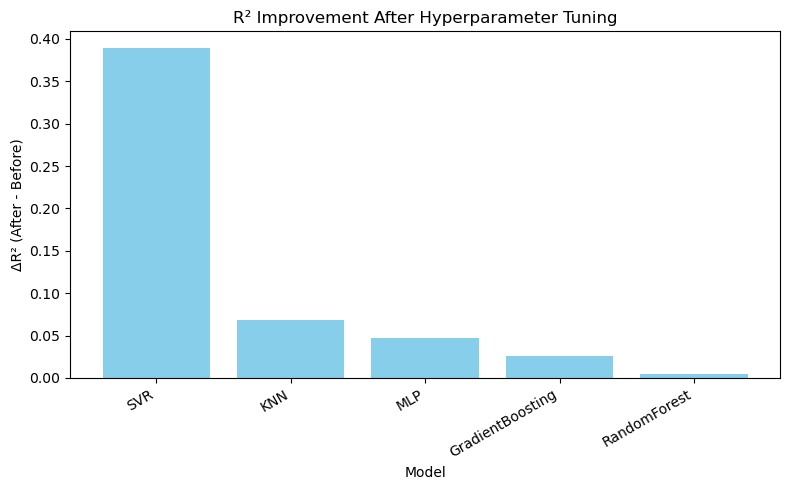

In [38]:
import matplotlib.pyplot as plt

# Plot R² improvement
comp["Delta_R2"] = comp["R2_Tuned"] - comp["R2_Untuned"]
comp = comp.sort_values("Delta_R2", ascending=False)
display(comp)

comp["R2_Improvement"] = comp["R2_Tuned"] - comp["R2_Untuned"]
plt.figure(figsize=(8,5))
plt.bar(comp["Model"], comp["R2_Improvement"], color='skyblue')
plt.title("R² Improvement After Hyperparameter Tuning")
plt.xlabel("Model")
plt.ylabel("ΔR² (After - Before)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


Blending the following models: ['RandomForest', 'GradientBoosting', 'KNN', 'SVR', 'MLP']
RandomForest      Test R2 = 0.741,  RMSE = 1396.896,  MAE = 29.489
GradientBoosting  Test R2 = 0.599,  RMSE = 2161.603,  MAE = 37.200
KNN               Test R2 = 0.874,  RMSE = 678.974,  MAE = 10.093
SVR               Test R2 = 0.586,  RMSE = 2231.825,  MAE = 37.343
MLP               Test R2 = 0.552,  RMSE = 2419.222,  MAE = 39.968

P_all shape: (1000, 5)
y_all shape: (1000,)

Number of weight combinations checked: 1001
Best weights (on ALL data):
  RandomForest    : 0.00
  GradientBoosting: 0.00
  KNN             : 0.90
  SVR             : 0.00
  MLP             : 0.10
Best R2 on ALL data (train+test): 0.886

Final Exhaustive-Blend Ensemble (evaluated on TEST)
Test R2   = 0.878
Test RMSE = 659.024
Test MAE  = 12.962

Ensemble R2 on ALL (recomputed): 0.8864465693060124


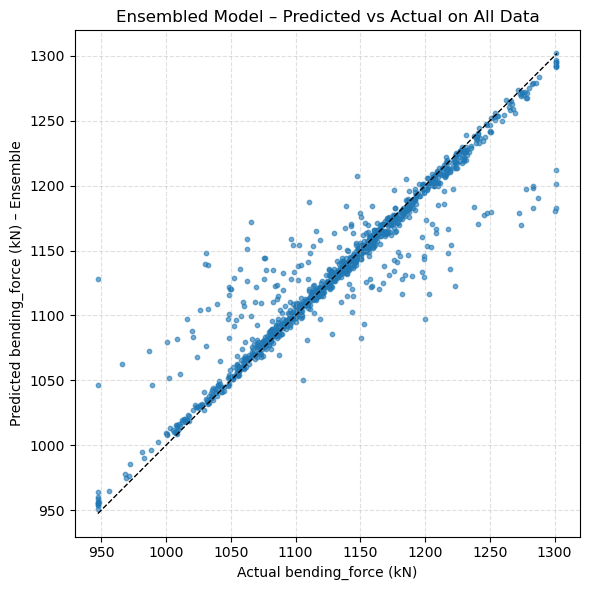

In [41]:
# ============================================================
# SECTION: Exhaustive Weight Search Ensemble
# ============================================================
# This section:
# - Uses predictions from already-trained models in saved_models
# - Searches over many weight combinations (coarse grid)
# - Uses all models in best_pipes/saved_models
# - Reports performance on TEST
# - THEN: applies best ensemble to ALL DATA and plots y vs ŷ
# ============================================================

import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1) Collect base models (tuned + TRAINED pipelines)
base_models = {
    "RandomForest":     saved_models["RandomForest"],
    "GradientBoosting": saved_models["GradientBoosting"],
    "KNN":              saved_models["KNN"],
    "SVR":              saved_models["SVR"],
    "MLP":              saved_models["MLP"],
}

model_names = list(base_models.keys())
n_models = len(model_names)
print("Blending the following models:", model_names)

# 2) Get predictions of each model on TRAIN and TEST
#    IMPORTANT: we DO NOT FIT here; we assume saved_models are already trained.
P_train = np.zeros((len(X_train), n_models))
P_test  = np.zeros((len(X_test),  n_models))

for j, (name, model) in enumerate(base_models.items()):
    P_train[:, j] = model.predict(X_train)
    P_test[:, j]  = model.predict(X_test)

    r2  = r2_score(y_test, P_test[:, j])
    rmse = mean_squared_error(y_test, P_test[:, j])
    mae  = mean_absolute_error(y_test, P_test[:, j])
    print(f"{name:16s}  Test R2 = {r2:.3f},  RMSE = {rmse:.3f},  MAE = {mae:.3f}")

# 3) Stack TRAIN + TEST predictions and targets for weight tuning
P_all = np.vstack([P_train, P_test])            # shape: (n_train + n_test, n_models)
y_all = np.concatenate([y_train.values, y_test.values])

print("\nP_all shape:", P_all.shape)
print("y_all shape:", y_all.shape)

# 4) Exhaustive search over weight combinations on a coarse grid
#    - weights in {0.0, 0.1, ..., 1.0}
#    - sum of weights = 1.0

grid_vals = np.arange(0.0, 1.01, 0.1)  # 0.0, 0.1, ..., 1.0

best_r2_all = -np.inf
best_weights = None

n_checked = 0

for ws in itertools.product(grid_vals, repeat=n_models):
    if abs(sum(ws) - 1.0) > 1e-9:
        continue  # only keep combos that sum to ~1

    w = np.array(ws)
    # Blend on ALL (train+test) predictions
    blend_all_candidate = P_all @ w
    r2_all = r2_score(y_all, blend_all_candidate)

    n_checked += 1
    if r2_all > best_r2_all:
        best_r2_all = r2_all
        best_weights = w

print(f"\nNumber of weight combinations checked: {n_checked}")
print("Best weights (on ALL data):")
for name, w in zip(model_names, best_weights):
    print(f"  {name:16s}: {w:.2f}")
print(f"Best R2 on ALL data (train+test): {best_r2_all:.3f}")

# 5) Apply the best weights to TEST predictions and evaluate
blend_test = P_test @ best_weights

r2_test  = r2_score(y_test, blend_test)
rmse_test = mean_squared_error(y_test, blend_test)
mae_test  = mean_absolute_error(y_test, blend_test)

print("\nFinal Exhaustive-Blend Ensemble (evaluated on TEST)")
print(f"Test R2   = {r2_test:.3f}")
print(f"Test RMSE = {rmse_test:.3f}")
print(f"Test MAE  = {mae_test:.3f}")

# ============================================================
# 6) Predicted vs Actual — Ensemble on ALL DATA (TRAIN + TEST)
# ============================================================

# Use best weights on all stacked predictions
blend_all = P_all @ best_weights   # ensemble prediction for every sample in y_all

# Optional: sanity-check R² (should match best_r2_all)
print("\nEnsemble R2 on ALL (recomputed):", r2_score(y_all, blend_all))

# Parity plot: predicted vs actual (on all data used in tuning)
plt.figure(figsize=(6, 6))
plt.scatter(y_all, blend_all, s=10, alpha=0.6)

# 45-degree reference line
y_min = min(y_all.min(), blend_all.min())
y_max = max(y_all.max(), blend_all.max())
plt.plot([y_min, y_max], [y_min, y_max], "k--", linewidth=1)

plt.xlabel("Actual bending_force (kN)")
plt.ylabel("Predicted bending_force (kN) – Ensemble")
plt.title("Ensembled Model – Predicted vs Actual on All Data")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [30]:
# ============================================================
# SECTION: Interactive Prediction Form (with range hints)
# ============================================================

import pandas as pd
import numpy as np
import ipywidgets as widgets
import joblib
from IPython.display import display, clear_output

# 1) Choose which model to use for prediction
#    Change this if another model/ensemble is your final choice
pipe = joblib.load("tuned_SVR_pipeline.joblib") 
prediction_model = pipe  # <-- adjust if needed

# 2) Use same feature columns as during training
feature_names = X_train.columns.tolist()

# Split into numeric and categorical features
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in feature_names if c not in num_features]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

# 3) Compute suggested ranges for numeric features (1%–99% quantiles)
range_info = {}
for col in num_features:
    q_low = X_train[col].quantile(0.01)
    q_hi  = X_train[col].quantile(0.99)
    range_info[col] = (q_low, q_hi)

range_df = pd.DataFrame(
    [(col, r[0], r[1]) for col, r in range_info.items()],
    columns=["feature", "q01 (low)", "q99 (high)"]
)

print("Suggested ranges for numeric features (based on training data 1%–99% quantiles):")
display(range_df)

# 4) Build input widgets
input_widgets = {}

# Numeric: FloatText with range hints
for col in num_features:
    low, high = range_info[col]
    desc = f"{col} [{low:.2f} – {high:.2f}]"
    w = widgets.FloatText(
        description=desc,
        style={"description_width": "260px"},
        layout=widgets.Layout(width="520px")
    )
    # default = median
    w.value = float(X_train[col].median())
    input_widgets[col] = w

# Categorical: Dropdown with allowed categories from training data
for col in cat_features:
    options = sorted(X_train[col].astype(str).unique())
    w = widgets.Dropdown(
        options=options,
        description=col,
        style={"description_width": "260px"},
        layout=widgets.Layout(width="520px")
    )
    input_widgets[col] = w

# 5) Button and output area
predict_button = widgets.Button(
    description="Predict bending_force",
    button_style="success",
    layout=widgets.Layout(width="260px")
)

output = widgets.Output()

def on_predict_clicked(b):
    with output:
        clear_output()
        # Collect values into a single-row DataFrame in correct column order
        data = {}
        for col in feature_names:
            widget = input_widgets[col]
            data[col] = [widget.value]
        X_new = pd.DataFrame(data)

        # Make prediction
        y_pred = prediction_model.predict(X_new)[0]

        print("Input parameters:")
        display(X_new)
        print(f"\nPredicted bending_force: {y_pred:.2f}")

predict_button.on_click(on_predict_clicked)

# 6) Display the UI
form_items = [input_widgets[col] for col in feature_names] + [predict_button, output]
form = widgets.VBox(form_items)

print("\nFill in the process parameters (values within the suggested numeric ranges are recommended):")
display(form)


Numeric features: ['entry_temperature', 'exit_temperature', 'rolling_speed', 'strip_thickness', 'deformation_resistance', 'friction_coefficient', 'roll_diameter', 'reduction_ratio', 'strain_rate']
Categorical features: ['material_grade', 'lubrication_type']
Suggested ranges for numeric features (based on training data 1%–99% quantiles):


,feature,q01 (low),q99 (high)
0,entry_temperature,1046.3257,1265.795600
1,exit_temperature,829.0916,969.605200
2,rolling_speed,1.5300,4.440100
3,strip_thickness,20.1898,34.840001
4,deformation_resistance,97.4989,191.504600
5,friction_coefficient,0.1020,0.296000
6,roll_diameter,577.8805,718.769800
7,reduction_ratio,0.2000,0.490000
8,strain_rate,0.5600,1.050100



Fill in the process parameters (values within the suggested numeric ranges are recommended):
